In [1]:
!pip install fft-conv-pytorch
!pip install scikit-image

In [2]:

import sys
import os

filepath = "../"  # Change this path for your Google drive setting.
sys.path.append(filepath)

In [3]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import skimage.io as skio
import torch.nn.functional as F
from torch.fft import fftshift, ifftshift, ifft2, fft2

# your helper modules (now in working dir)
from utils import *
from self_calibration import *
from overlap_add_save import *

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
self_calib_param_lr    = 1e-5
learning_rate          = 1e-3
seed                   = 0

data_path              = 'Data/Diversity_Images_SystemAberration_Lymph.tif'
zernike_coeff_path     = 'Data/appliedCoeff.txt'


# ─── Calibration options ────────────────────────────────────────────────────────
use_self_calibration                = 1             # 1 or 0
use_learnable_scales   = 0             # 1 or 0
use_scheduler          = 0             # 1 or 0

# ─── Optimization hyperparameters ───────────────────────────────────────────────
epochs                 = 400
fourier_loss_weight    = 0.001

# ─── Zernike orders ─────────────────────────────────────────────────────────────
n_max                  = 14
n_max_estimated        = 14

# ─── Optical parameters ────────────────────────────────────────────────────────
NA                     = 0.3
camera_pixel_size      = 0.543e-6
wavelength             = 0.513e-6
n_imm                  = 1.33
gaussian_sigma         = 10.0e-3

avg_background         = 0.0
psf_size               = 101
img_num_factor         = 1
use_2photon            = 0

### Dxp: diameter of the deformable mirror in m
Dxp = 10e-3
gaussian_sigma
pad_w, pad_h = psf_size - 1, psf_size - 1

In [5]:
# ─── Setup seeds ────────────────────────────────────────────────────
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [31]:
# ─── Zernike basis and defining the beam and Deformable mirror in the pupil plane────────────────────────────────────────────────────────────
M = 255
_, zernikes = zernike_pd_generation_higher_order(6, n_max, M, camera_pixel_size, wavelength, NA)
zernikes = zernikes.to(device)

k = 2 * np.pi * n_imm / wavelength  # wavenumber

maxSpatialFreq = ((NA) / wavelength) #/ (1 / (2 * cameraPixelSize))
maxSpatialFreqRatio = maxSpatialFreq / (1 / (2 * camera_pixel_size))

### generation of spatial frequency in the coordinate space
kx, ky = torch.fft.fftfreq(M, d = (camera_pixel_size)), torch.fft.fftfreq(M, d = (camera_pixel_size))
kx, ky = torch.fft.fftshift(kx), torch.fft.fftshift(ky)

kxx, kyy = torch.meshgrid(kx, ky)
kxx, kyy = kxx.to(device), kyy.to(device)

beam_crop = (kxx**2 + kyy**2) <= maxSpatialFreq**2
dm_crop = (kxx**2 + kyy**2) <= (maxSpatialFreq * (5.75 / 5.04))**2

beam_crop = beam_crop.float()
dm_crop = dm_crop.float()


x, y = torch.meshgrid(torch.linspace(-Dxp/2, Dxp/2, M), torch.linspace(-Dxp/2, Dxp/2, M))
sigma = gaussian_sigma
# gaussian = beam_crop * torch.exp(-1*(x**2+y**2)/(2 * (sigma)**2)).float().to(device)
gaussian = beam_crop * torch.exp(-1*(x**2+y**2)/(2 * (sigma)**2)).float().to(device)

padding_w_ = M // 2
padding_h_ = M // 2

## padding goes backwards: in the form of (left, right, top, bottom, front, back)
dm_crop_padded = torch.nn.functional.pad(dm_crop, (padding_h_, padding_h_, padding_w_, padding_w_), 'constant', 0)
beam_crop_padded = torch.nn.functional.pad(beam_crop, (padding_h_, padding_h_, padding_w_, padding_w_), 'constant', 0)
gaussian_padded = torch.nn.functional.pad(gaussian, (padding_h_, padding_h_, padding_w_, padding_w_), 'constant', 0)


n_max_ansi: 14
order_max: 6
[0, 2, 1, 4, 3, 5, 7, 8, 6, 9, 12, 13, 11, 14, 10, 18, 17, 19, 16, 20, 15, 24, 23, 25, 22, 26, 21, 27]


In [8]:
# ─── Load applied coefficients ────────────────────────────────────────────────
coeffs = np.loadtxt(zernike_coeff_path)
coeffs = coeffs[::img_num_factor]
coeffs = torch.tensor(coeffs, dtype=torch.float32).to(device)

# ─── Load data ────────────────────────────────────────────────────────────────
phase_added = skio.imread(data_path).astype(np.float32)
bg = np.min(phase_added[phase_added>0])
phase_added = np.clip(phase_added - bg, 0, None)
phase_added /= phase_added.max()
phase_added = np.squeeze(phase_added)[::img_num_factor]
phase_added = torch.from_numpy(phase_added).to(device)

# ─── Initialize estimates ─────────────────────────────────────────────────────
found_zernike_coef = torch.zeros(n_max+1, dtype=torch.float32, requires_grad=True, device=device)
found_object = phase_added[0].clone().requires_grad_(True).to(device)

found_object = found_object.requires_grad_().to(device)

amplitude_scale_x = torch.tensor([1.0]).to(device)
amplitude_scale_y = torch.tensor([1.0]).to(device)
offset_x = torch.tensor([0.0]).to(device)
offset_y = torch.tensor([0.0]).to(device)

grid_adjustment = torch.tensor([1.0]).to(device)

rotation_angle = torch.tensor([0.0]).to(device)
self_calib_params = [amplitude_scale_x, amplitude_scale_y, offset_x, offset_y, rotation_angle, grid_adjustment]

astig_scale_factor = torch.tensor([0.0]).to(device)
defocus_scale_factor = torch.tensor([0.0]).to(device)
trefoil_scale_factor = torch.tensor([0.0]).to(device)
coma_scale_factor = torch.tensor([0.0]).to(device)
tetrafoil_scale_factor = torch.tensor([0.0]).to(device)
secondary_astig_scale_factor = torch.tensor([0.0]).to(device)
spherical_aberr_scale_factor = torch.tensor([0.0]).to(device)
scale_factors_list = [astig_scale_factor, defocus_scale_factor, trefoil_scale_factor, coma_scale_factor, tetrafoil_scale_factor, secondary_astig_scale_factor, spherical_aberr_scale_factor]




if (use_self_calibration != 1) and (use_learnable_scales != 1):
    print("Using Neither Self-Calibration on Pupil/Wavefront nor Learnable Scales")
    optimizer = torch.optim.Adam([found_zernike_coef, found_object], lr=learning_rate)
elif (use_self_calibration == 1) and (use_learnable_scales != 1):
    print("Using Self-Calibration on Pupil/Wavefront but NOT using Learnable Scales")
    for param in self_calib_params:
        param.requires_grad_()
    optimizer = torch.optim.Adam([{'params': found_zernike_coef, 'lr': 1*learning_rate},
                            #   {'params': found_zernike_coef_diff_fovs, 'lr': 1*learning_rate},
                              {'params': found_object, 'lr':  1*learning_rate},
                              {'params': amplitude_scale_x, 'lr': self_calib_param_lr},
                              {'params': amplitude_scale_y, 'lr': self_calib_param_lr},
                              {'params': offset_x, 'lr': self_calib_param_lr}, # 0.1
                              {'params': offset_y, 'lr': self_calib_param_lr}, # 0.1
                              {'params': rotation_angle, 'lr': self_calib_param_lr},
                              {'params': grid_adjustment, 'lr': self_calib_param_lr}], lr = learning_rate) # 0.5
elif (use_self_calibration != 1)  and (use_learnable_scales == 1):
    print("NOT using Self-Calibration on Pupil/Wavefront but using Learnable Scales")
    for scale_factor in scale_factors_list:
        scale_factor.requires_grad_()
    optimizer = torch.optim.Adam([{'params': found_zernike_coef, 'lr': learning_rate},
                            #   {'params': found_zernike_coef_diff_fovs, 'lr': 1*learning_rate},
                              {'params': found_object, 'lr': learning_rate},
                              {'params': astig_scale_factor, 'lr': 0.1 * learning_rate},
                              {'params': defocus_scale_factor, 'lr': 0.1 * learning_rate},
                                {'params': trefoil_scale_factor, 'lr': 0.1 * learning_rate},
                                {'params': coma_scale_factor, 'lr': 0.1 * learning_rate},
                                {'params': tetrafoil_scale_factor, 'lr': 0.1 * learning_rate},
                                {'params': secondary_astig_scale_factor, 'lr': 0.1 * learning_rate},
                                {'params': spherical_aberr_scale_factor, 'lr': 0.1 * learning_rate}], lr = learning_rate)
elif (use_self_calibration == 1)  and (use_learnable_scales == 1):
    print("Using Self-Calibration on Pupil/Wavefront and Learnable Scales")
    for scale_factor in scale_factors_list:
        scale_factor.requires_grad_()
    for param in self_calib_params:
        param.requires_grad_()
    optimizer = torch.optim.Adam([{'params': found_zernike_coef, 'lr': learning_rate},
                            #   {'params': found_zernike_coef_diff_fovs, 'lr': opt.spatially_varying_weight*learning_rate},
                              {'params': found_object, 'lr': learning_rate},
                              {'params': amplitude_scale_x, 'lr': self_calib_param_lr},
                              {'params': amplitude_scale_y, 'lr': self_calib_param_lr},
                              {'params': offset_x, 'lr': self_calib_param_lr}, # 0.1
                              {'params': offset_y, 'lr': self_calib_param_lr}, # 0.1
                              {'params': rotation_angle, 'lr': self_calib_param_lr},
                              {'params': grid_adjustment, 'lr': self_calib_param_lr},
                              {'params': astig_scale_factor, 'lr': 0.1 * learning_rate},
                              {'params': defocus_scale_factor, 'lr': 0.1 * learning_rate},
                                {'params': trefoil_scale_factor, 'lr': 0.1 * learning_rate},
                                {'params': coma_scale_factor, 'lr': 0.1 * learning_rate},
                                {'params': tetrafoil_scale_factor, 'lr': 0.1 * learning_rate},
                                {'params': secondary_astig_scale_factor, 'lr': 0.1 * learning_rate},
                                {'params': spherical_aberr_scale_factor, 'lr': 0.1 * learning_rate}], lr = learning_rate)



optimizer = torch.optim.Adam([found_zernike_coef, found_object], lr=learning_rate)
if use_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)
L1_loss = torch.nn.L1Loss()


Using Self-Calibration on Pupil/Wavefront but NOT using Learnable Scales


In [32]:
## don't use the first two coefficients (tip/tilt)
mask = torch.ones_like(found_zernike_coef).to(device)

mask[:3] = 0
if n_max_estimated < len(mask):
    mask[n_max_estimated+1:] = 0

train_loss_curve = []

for epoch_idx in range(epochs):


        epoch_loss = 0
        for pair_idx in tqdm(range(len(coeffs)), desc="epoch {} optimization".format(epoch_idx)):
            optimizer.zero_grad()
            found_object.requires_grad_()
            found_zernike_coef.requires_grad_()
            # found_zernike_coef_diff_fovs.requires_grad_()


            ## create and apply learnable scales IF the option is enabled
            if use_learnable_scales:
                for scale_factor in scale_factors_list:
                    scale_factor.requires_grad_()
                filler_zero = torch.tensor([0.0]).to(device)
                scale_factors = torch.cat([filler_zero, filler_zero, filler_zero, astig_scale_factor, defocus_scale_factor, astig_scale_factor, trefoil_scale_factor, coma_scale_factor, coma_scale_factor, trefoil_scale_factor, tetrafoil_scale_factor, secondary_astig_scale_factor, spherical_aberr_scale_factor, secondary_astig_scale_factor, tetrafoil_scale_factor]).to(device)
                scale_factors = torch.tensor([1.0]).to(device) + scale_factors
                if scale_factors.numel() < found_zernike_coef.numel():
                    pad_size = found_zernike_coef.numel() - scale_factors.numel()
                    scale_factors = torch.cat([
                        scale_factors,
                        torch.ones(pad_size, device=device)
                    ])


            random_added_coeff = coeffs[pair_idx]
            random_added_coeff = 1*random_added_coeff
            assert len(random_added_coeff) == len(found_zernike_coef)


            ## ### Beam Phase is defined on the Fourier Plane
            found_coeffs_all_fovs = found_zernike_coef
            estimated_phase = torch.einsum('i, ikl -> kl', 1e-6 * found_zernike_coef, zernikes)

            ## define the beam phase on the DM plane along with the applied phase from the DM
            if use_learnable_scales:
                applied_phase = torch.einsum("i,ijk->jk", 1e-6 * scale_factors * random_added_coeff, zernikes)
            else:
                applied_phase = torch.einsum("i,ijk->jk", 1e-6 * random_added_coeff, zernikes)


            ####### Apply Self Calibration ########
            rotated_applied_phase = rotation_transform(applied_phase, rotation_angle, device)
            total_phases = estimated_phase + rotated_applied_phase

            beam_amplitude_scaled = scale_transform(gaussian, grid_adjustment, grid_adjustment, device)
            beam_amplitude_scaled = scale_transform(beam_amplitude_scaled, amplitude_scale_x, amplitude_scale_y, device)
            beam_amplitude_scaled_shifted = shift_transform(beam_amplitude_scaled, offset_x, offset_y, device)
            beam_amplitude_scaled_shifted_cropped = dm_crop * beam_amplitude_scaled_shifted

            beam_phases_scaled = scale_transform(total_phases, grid_adjustment, grid_adjustment, device)

            amplitude = beam_amplitude_scaled_shifted
            psf = fftshift(ifft2(ifftshift(amplitude * torch.exp(1j * k * beam_phases_scaled))))

            if use_2photon == 1:
                psf = torch.abs(psf)**4
            else:
                psf = torch.abs(psf)**2
            psf = psf[M//2 - psf_size//2:M//2 + psf_size//2 + 1, M//2 - psf_size//2:M//2 + psf_size//2 +1]
            psf = psf / psf.sum()


            object = F.pad(found_object, (pad_w//2, pad_w//2, pad_h//2, pad_h//2), mode='constant', value=0)
            aberrated_img = fft_conv(object.unsqueeze(0).unsqueeze(0), torch.flip(psf.unsqueeze(0).unsqueeze(0), [2,3]), None, 0)

            observed_img = phase_added[pair_idx]
            recon_observed_img_FT = torch.real(torch.fft.fft2(aberrated_img))
            observed_img_FT = torch.real(torch.fft.fft2(observed_img)) #### ifft2
            Fourier_loss = L1_loss(recon_observed_img_FT.squeeze(), observed_img_FT)
            recon_loss = L1_loss(aberrated_img.squeeze(), observed_img) 


            loss = recon_loss + fourier_loss_weight * Fourier_loss

            loss.backward()

            found_zernike_coef.grad.mul_(mask)


            optimizer.step()

            epoch_loss += loss.item()

            if use_scheduler:
                scheduler.step()
            with torch.no_grad():
                found_object.data.clamp_(min=torch.tensor([0]).to(device))
                for scale_factor in scale_factors_list:
                    scale_factor.data.clamp_(min=torch.tensor([-1.0]).to(device))
        train_loss_curve.append(epoch_loss)

epoch 371 optimization:   5%|▍         | 1/22 [00:00<00:00, 62.67it/s]


KeyboardInterrupt: 

In [33]:
from datetime import datetime

# Base results path
base_results = "Results"

# Create a timestamp string, e.g. "20250429_163045"
ts = datetime.now().strftime("%Y%m%d_%H")

# Full path for this run
results_dir = os.path.join(base_results, ts)
os.makedirs(results_dir, exist_ok=True)

zernike_coeffs_np = found_zernike_coef.detach().cpu().numpy()
found_obj_np = found_object.detach().cpu().numpy()

# Save Zernike coefficients
np.savetxt(os.path.join(results_dir, "found_zernike_coefficients.txt"),
           zernike_coeffs_np, fmt="%.6e")

# Save reconstructed object
skio.imsave(os.path.join(results_dir, "estimated_object.tif"), found_obj_np)

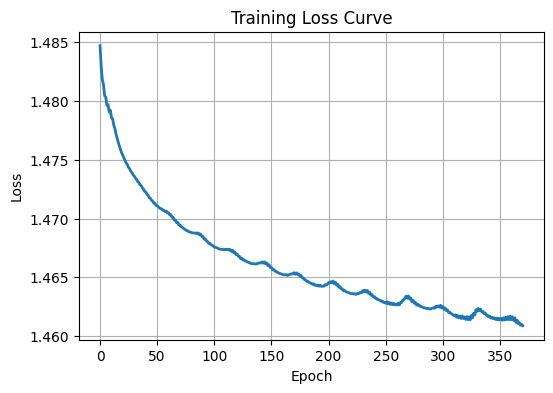

In [34]:
# — Plot training loss curve —
plt.figure(figsize=(6,4))
plt.plot(train_loss_curve, lw=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

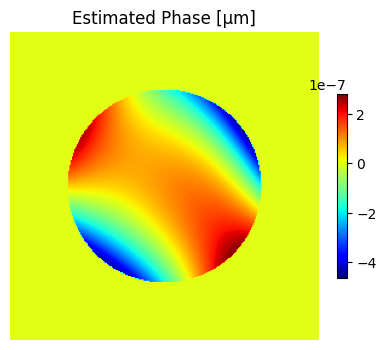

In [35]:
# — Compute & show estimated phase map —
estimated_phase = torch.einsum('i,ijk->jk', 1e-6 * found_zernike_coef, zernikes)
est_phase_np    = estimated_phase.detach().cpu().numpy()

plt.figure(figsize=(5,4))
plt.imshow(est_phase_np, cmap='jet')
plt.colorbar(shrink=0.6)
plt.title('Estimated Phase [µm]')
plt.axis('off')
plt.show()

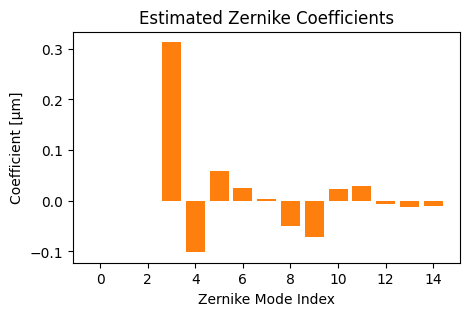

In [36]:
# — Bar chart of learned Zernike coefficients —
coeffs_np = found_zernike_coef.detach().cpu().numpy()
modes     = np.arange(len(coeffs_np))

plt.figure(figsize=(5,3))
plt.bar(modes, coeffs_np, color='C1')
plt.xlabel('Zernike Mode Index')
plt.ylabel('Coefficient [µm]')
plt.title('Estimated Zernike Coefficients')
plt.show()

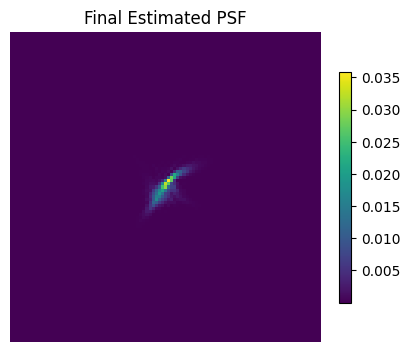

In [37]:
# Estimated phase (in radians) from learned Zernike coefficients
estimated_phase = torch.einsum('i,ijk->jk', 1e-6 * found_zernike_coef, zernikes)

# Use the original Gaussian amplitude
amp = gaussian

# Compute PSF via Fourier optics: IFT of pupil amplitude × phase
psf_est = fftshift(ifft2(ifftshift(amp * torch.exp(1j * k * estimated_phase))))

# Intensity (square or fourth power)
psf_est = torch.abs(psf_est)**(4 if use_2photon else 2)

# Crop to PSF size
psf_est = psf_est[M//2 - psf_size//2 : M//2 + psf_size//2 + 1,
                  M//2 - psf_size//2 : M//2 + psf_size//2 + 1]

# Normalize
psf_est = psf_est / psf_est.sum()

# Convert to NumPy for plotting
psf_np = psf_est.detach().cpu().numpy()

# Plot the estimated PSF
plt.figure(figsize=(5,5))
plt.imshow(psf_np, cmap='viridis')
plt.colorbar(shrink=0.6)
plt.title('Final Estimated PSF')
plt.axis('off')
plt.show()

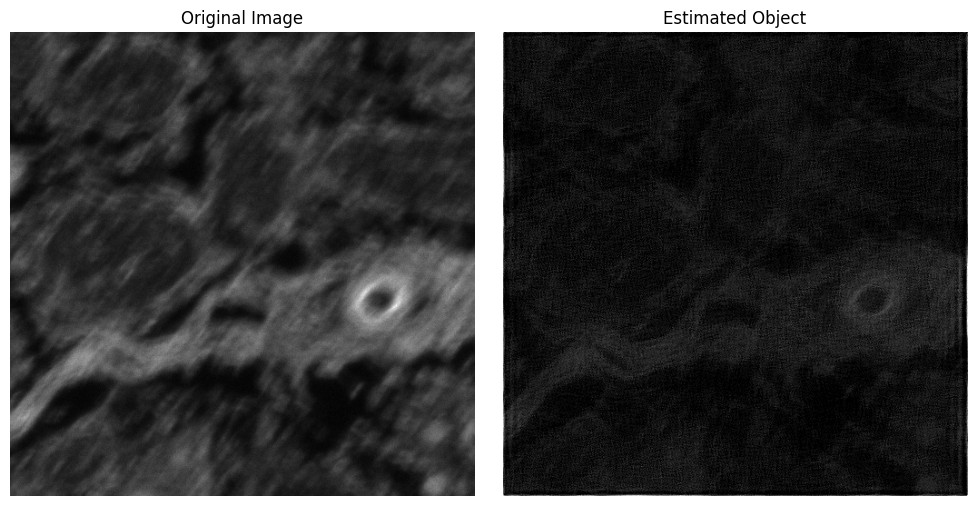

In [38]:
# Display original vs. estimated object side-by-side
orig_np   = phase_added[0].detach().cpu().numpy()
est_obj_np = found_object.detach().cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(orig_np, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(est_obj_np, cmap='gray')
axs[1].set_title('Estimated Object')
axs[1].axis('off')

plt.tight_layout()
plt.show()